In [ ]:
import data_analysis_tools as da


data = da.file_ops.read_csv('./files/Iris.csv', sep=',', as_array=True)

# some formatting
data.pop(0)
for i in range(len(data)):
    data[i].pop(0)
    data[i] = (da.parser.parse_vector2float([data[i][0], data[i][2]]), data[i][4])
data[:10]

In [ ]:
unlabeled_data = [i for i, _ in data]
unlabeled_data[:10]

In [ ]:
len(unlabeled_data)

In [ ]:
da.r.seed(0)
cls = da.ml.KMeans(k=3)
cls.train(unlabeled_data)
cls.means

In [ ]:
for index in range(len(data)):
    print(f'actutal: {data[index][1]}, predicted: {cls.classify(data[index][0])} ')

In [ ]:
def squared_clustering_errors(inputs, k):
    clusterer = da.ml.KMeans(k)
    clusterer.train(inputs)
    means = clusterer.means
    assignments = map(clusterer.classify, inputs)

    return sum(da.squared_distance(input, means[cluster]) 
    for input, cluster in zip(inputs, assignments))

squared_clustering_errors(unlabeled_data, 3)

In [ ]:
ks = range(1, len(unlabeled_data) // 3 + 1)
errors = [squared_clustering_errors(unlabeled_data, ki) for ki in ks]

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 12))
plt.plot(ks, errors)
plt.xticks(ks)
plt.xlabel('k')
plt.ylabel('total squared error')
plt.title('Total Error vs. # of Clusters')
plt.show()

In [ ]:
# clustering colors (image)
image_path = "./files/ultrasmall.jpg"
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

img = mpimg.imread(image_path)
img.shape

In [ ]:
top_row = img[0]
print(top_row.shape)


pixels = [pixel/255 for row in img for pixel in row]
print(pixels[:10])

In [ ]:
import data_analysis_tools as da
clusterer = da.ml.KMeans(8)
clusterer.train(pixels)

In [ ]:
clusterer.means

In [ ]:
import copy
def recolor(pixel):
    cluster = clusterer.classify(pixel)
    res = copy.copy(clusterer.means[cluster])
    for i in range(3):
        tmp = int(res[i] * 255)
        if tmp > 255:
            res[i] = 255
        elif tmp < 0:
            res[i] = 0
        else:
            res[i] = tmp
    
    return res

new_img = [[recolor(pixel/255) for pixel in row] for row in img]
mpimg.imsave('img.jpg', new_img)
# not working!!!!!!!!!!!!!

In [ ]:
# bottom up hierarchical

leaf1 = ([10, 20],) # to make a 1-tuple you need the trailing comma
leaf2 = ([30, -15],) # otherwise Python treats the parentheses as parentheses

merged = (1, [leaf1, leaf2])
merged

In [121]:
def is_leaf(cluster):
    """a cluster is a leaf if it has length 1"""
    return len(cluster) == 1

def get_children(cluster):
    """returns the two children of this cluster if it's a merged cluster;
    raises an exception if this is a leaf cluster."""
    if is_leaf(cluster):
        raise TypeError('a leaf cluster has no children')
    else:
        return cluster[1]

def get_values(cluster):
    """returns the value in this cluster (if it's a leaf cluster)
    or all the values in the leaf clusters below it (if it's not)"""
    if is_leaf(cluster):
        return cluster
    else:
        return [value for child in get_children(cluster) for value in get_values(child)]

def cluster_distance(cluster1, cluster2, distance_agg=min):
    return distance_agg([
        da.euclidean(input1, input2) 
        for input1 in get_values(cluster1)
        for input2 in get_values(cluster2)
    ])

def get_merge_order(cluster):
    if is_leaf(cluster):
        return float('inf')
    else:
        return cluster[0] # merge_order is first element of 2-tuple

def bottom_up_cluster(inputs, distance_agg=min):

    # at start every input is a leaf cluster
    clusters = [(input,) for input in inputs]

    # go on till we have only one cluster
    while len(clusters) > 1:
        # find two closest clusters
        c1, c2 = min([
            (cluster1, cluster2) for i, cluster1 in enumerate(clusters)
            for cluster2 in clusters[:i]],
            key=lambda x: cluster_distance(x[0], x[1], distance_agg))
        
        # remove them from the list of clusters
        clusters.remove(c1)
        clusters.remove(c2)
        # clusters = [c for c in clusters if c != c1 and c != c2]

        # merge them, using merge_order = # of clusters left
        merged_cluster = (len(clusters), [c1, c2])

        # and add their merge
        clusters.append(merged_cluster)

    # there is only 1 cluster left, return it
    return clusters[0]


In [123]:
base_cluster = bottom_up_cluster(unlabeled_data)

In [197]:
a_cluster = base_cluster[1][1][1][0][1][0][1][0][1][0][1][0][1][0][1][0][1][0][1][0][1][0][1][0][1][1]
a_cluster

(79,
 [(92,
   [(109, [(142, [([5.2, 1.5],), ([5.2, 1.5],)]), ([5.3, 1.5],)]),
    ([5.2, 1.4],)]),
  (143, [([5.4, 1.5],), ([5.4, 1.5],)])])

In [196]:
get_values(a_cluster)

[[5.2, 1.5], [5.2, 1.5], [5.3, 1.5], [5.2, 1.4], [5.4, 1.5], [5.4, 1.5]]

In [214]:
def generate_clusters(base_cluster, num_clusters):
    # start with a list with just the base cluster
    clusters = [base_cluster]

    # as long as we don't gave enough clusters yet...
    while len(clusters) < num_clusters:
        # choose the last-merged of our clusters
        next_cluster = min(clusters, key=get_merge_order)
        # remove it from the list
        clusters.remove(next_cluster)
        # and add its children to the list
        clusters.extend(get_children(next_cluster))

    return clusters

In [244]:
base_cluster_max = bottom_up_cluster(unlabeled_data, max)

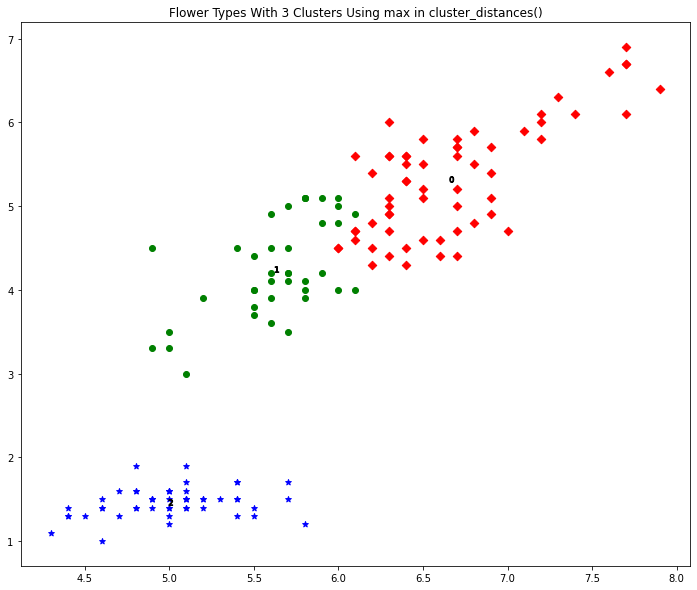

In [261]:
n = 3
n_clusters = [get_values(cluster) for cluster in generate_clusters(base_cluster_max, n)]

plt.figure(figsize=(12, 10))
for i, cluster, marker, color in zip(range(n), n_clusters, ['D', 'o', '*', 'x', 'p'], ['r', 'g', 'b', 'y', 'cyan']):
    xs, ys = zip(*cluster)
    plt.scatter(xs, ys, color=color, marker=marker)
    x, y = da.vector_mean(cluster)
    plt.plot(x, y, marker='$' + str(i) + '$', color='black')

plt.title(f"Flower Types With {n} Clusters Using max in cluster_distances()")
plt.show()

In [251]:
base_cluster_min = bottom_up_cluster(unlabeled_data, min)

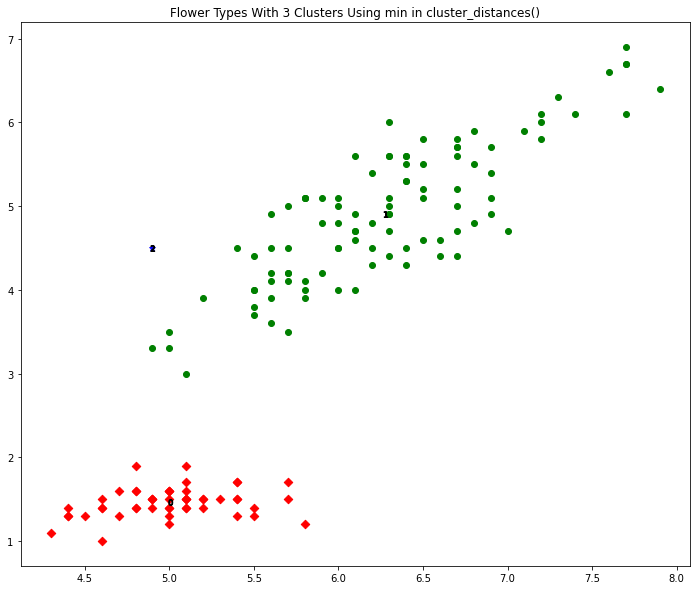

In [262]:
n = 3
n_clusters = [get_values(cluster) for cluster in generate_clusters(base_cluster_min, n)]

plt.figure(figsize=(12, 10))
for i, cluster, marker, color in zip(range(n), n_clusters, ['D', 'o', '*', 'x', 'p'], ['r', 'g', 'b', 'y', 'cyan']):
    xs, ys = zip(*cluster)
    plt.scatter(xs, ys, color=color, marker=marker)
    x, y = da.vector_mean(cluster)
    plt.plot(x, y, marker='$' + str(i) + '$', color='black')

plt.title(f"Flower Types With {n} Clusters Using min in cluster_distances()")
plt.show()

In [250]:
base_cluster_mean = bottom_up_cluster(unlabeled_data, da.mean)

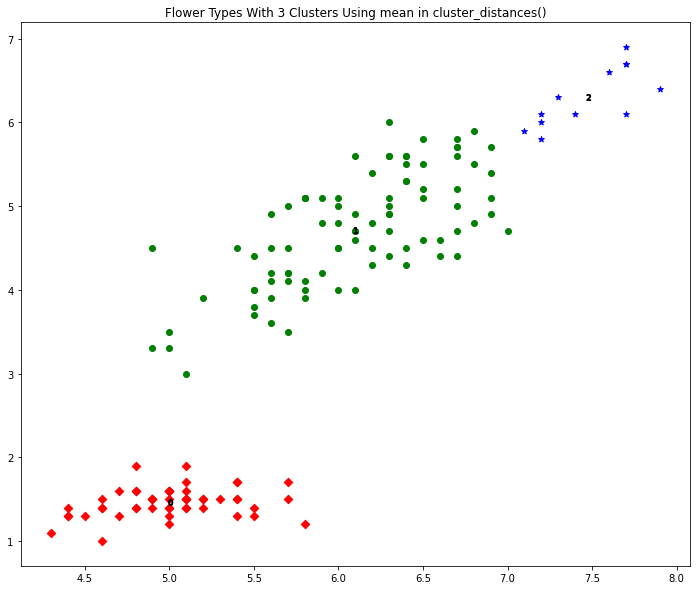

In [263]:
n = 3
n_clusters = [get_values(cluster) for cluster in generate_clusters(base_cluster_mean, n)]

plt.figure(figsize=(12, 10))
for i, cluster, marker, color in zip(range(n), n_clusters, ['D', 'o', '*', 'x', 'p'], ['r', 'g', 'b', 'y', 'cyan']):
    xs, ys = zip(*cluster)
    plt.scatter(xs, ys, color=color, marker=marker)
    x, y = da.vector_mean(cluster)
    plt.plot(x, y, marker='$' + str(i) + '$', color='black')

plt.title(f"Flower Types With {n} Clusters Using mean in cluster_distances()")
plt.show()

In [254]:
base_cluster_median = bottom_up_cluster(unlabeled_data, da.median)

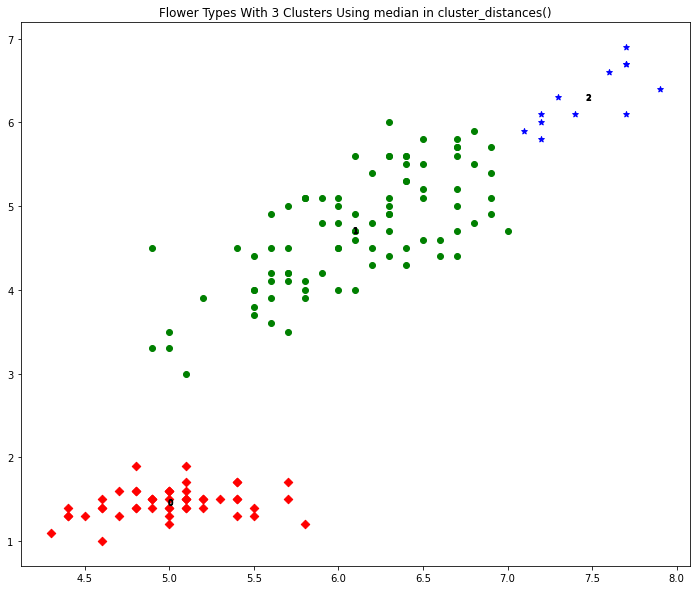

In [264]:
n = 3
n_clusters = [get_values(cluster) for cluster in generate_clusters(base_cluster_median, n)]

plt.figure(figsize=(12, 10))
for i, cluster, marker, color in zip(range(n), n_clusters, ['D', 'o', '*', 'x', 'p'], ['r', 'g', 'b', 'y', 'cyan']):
    xs, ys = zip(*cluster)
    plt.scatter(xs, ys, color=color, marker=marker)
    x, y = da.vector_mean(cluster)
    plt.plot(x, y, marker='$' + str(i) + '$', color='black')

plt.title(f"Flower Types With {n} Clusters Using median in cluster_distances()")
plt.show()